In [152]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error, fbeta_score

import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import optuna
import unicodedata

import lightgbm as lgb

In [153]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    seed = 42
    #seed = 2023
    #seed = 1111
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    target_bins = 20
    year_bins = 20
    num_boost_round = 10000
    stopping_rounds = 1500
    n_trials = 1500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"

In [154]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

def get_score(y_true, y_pred):
    best_score = -np.inf
    for i in tqdm(np.arange(0, 1, 0.001)):
        y_pred_class = [1 if p >= i else 0 for p in y_pred]
        score = fbeta_score(y_true, y_pred_class, beta=2)
        if score > best_score:
            best_score = score
            best_threshold = i
    return best_score, best_threshold

In [155]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [156]:
# ===================================================================
#  preprocessing
# ===================================================================
# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3011:2011,
        3015:2015,
        3017:2017,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df
all_data = pre_year(all_data)

# manufacturer
all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))
manufacturer_map = {
    'niѕsan':'nissan',
    'nisѕan':'nissan',
    'subαru':'subaru',
    'toyotа':'toyota',
    'sαturn':'saturn',
    'аcura':'acura',
    'vоlkswagen':'volkswagen',
    'lexuѕ':'lexus',
    'ᴄhrysler':'chrysler',
}
all_data["manufacturer"] = all_data["manufacturer"].replace(manufacturer_map)

# fuel
## 欠損値 train: 1239, test, 1495 
## わざと欠損値にしている訳ではなさそう？
all_data["fuel"].fillna(value="Unknown", inplace=True)


# odometer
## 後でvalidationを作るときに直そう

# title_status
## 欠損値 train: 456, test: 229
all_data["title_status"].fillna(value="Unknown", inplace=True)

# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df
all_data = pre_size(all_data)

# type
## 欠損値 train: 456, test: 229
all_data["type"].fillna(value="Unknown", inplace=True)


# state
## 欠損値 train: 3304, test: 3029
all_data["state"].fillna(value="Unknown", inplace=True)

In [157]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=20, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(skf.split(X=train, y=train["price_map"])):
    train.loc[val, "fold"] = i
print(train["fold"].value_counts())
print(train.groupby("fold")["price"].mean().std())

fold
1.0    5507
0.0    5507
2.0    5506
4.0    5506
3.0    5506
Name: count, dtype: int64
8.784566908616718


In [158]:
# ===================================================================
#  Variance by category
# ===================================================================
all_data = pd.concat([train, test], ignore_index=True)
tmp_ = ['region',  'manufacturer', 'condition', 'cylinders',
       'fuel',  'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state',  'year_map',]
df = all_data[(all_data["odometer"] > 100)&(all_data["odometer"] < 400000)].reset_index(drop=True)
tmp = []
for col in tmp_:
    tmp.append(df.groupby(col)["odometer"].mean().std())
df = pd.DataFrame(zip(tmp_, tmp, [len(train[col].unique()) for col in tmp_]), columns=["feature", "std", "len"],)
display(df.sort_values("std", ascending=False, ignore_index=True))

,feature,std,len
0,year_map,33400.067098,20
1,condition,26899.720306,6
2,fuel,19292.666186,6
3,region,17761.052586,372
4,manufacturer,16545.615833,37
5,paint_color,16320.395312,12
6,type,16318.821524,14
7,cylinders,13385.064899,8
8,drive,12651.327741,3
9,title_status,11325.772185,7


In [159]:
all_data.columns

Index(['id', 'region', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'price', 'flag', 'year_map',
       'price_map', 'fold'],
      dtype='object')

In [160]:
# ===================================================================
#  use features
# =================================================================== 
## numerical
CFG.numerical_features = ['year', "odometer"]

## category
CFG.categorical_features = ['region','manufacturer', 'condition', 'cylinders','fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'state'
                            ]
CFG.target_encoding_features = ['manufacturer','condition', 'transmission',]
CFG.count_encoding_features = ["region",'cylinders',"state"]
CFG.max_encoding_features = ['cylinders']
CFG.std_encoding_features = ["fuel"]
CFG.min_encoding_features = []
CFG.median_encoding_features = ["manufacturer", "condition"]


## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [161]:
train["label"] = np.where(train["price"]>15000, 1, 0)
print(train["label"].mean())

0.36074386168821737


In [162]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    test_df = test.copy()
    
    # odometerの補正
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["year_map"])["odometer"].mean().reset_index()
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame):
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="year_map", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    test_df = replace_odometer(test_df, fillna_map)
    
    
    """
    def add_odometer_per_year(df: pd.DataFrame):
        df["elapsed_year"] = 2023 - df["year"]
        df["odometer_per_year"] = df["odometer"] / df["elapsed_year"]
        return df
    X_train = add_odometer_per_year(X_train)
    X_valid = add_odometer_per_year(X_valid) 
    test_df = add_odometer_per_year(test_df)
    """
    
    
    # CFG.categorical_featuresをcategory型に変換
    for col in CFG.categorical_features:
        X_train[col] = X_train[col].astype("category")
        X_valid[col] = X_valid[col].astype("category")
        test_df[col] = test_df[col].astype("category")
        
        
    # params
    lgb_param = {
        "objective": "binary",
        "metric": 'binary_logloss',
        "verbosity": -1,
        "seed" : CFG.seed,
    }


    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["label"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["label"], categorical_feature = CFG.categorical_features,)
    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    num_boost_round=CFG.num_boost_round, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    print(f"fold{fold}:", get_score(y_true=X_valid["label"], y_pred=X_valid["pred"]))
    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["label"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

100%|██████████| 1000/1000 [00:07<00:00, 130.84it/s]


fold0: (0.7891656913559606, 0.126)


100%|██████████| 1000/1000 [00:07<00:00, 141.26it/s]


fold1: (0.7884240006789442, 0.14)


100%|██████████| 1000/1000 [00:06<00:00, 144.30it/s]


fold2: (0.7930131004366814, 0.17200000000000001)


100%|██████████| 1000/1000 [00:06<00:00, 143.14it/s]


fold3: (0.7904802379940501, 0.136)


100%|██████████| 1000/1000 [00:06<00:00, 145.02it/s]


fold4: (0.7885027885027884, 0.145)
====== CV score ======


100%|██████████| 1000/1000 [00:26<00:00, 38.22it/s]

(0.7885262049522774, 0.139)


In [163]:
oof_df[oof_df["label"] == 1].shape

(9932, 22)

Confusion Matrix:
[[   0 8637]
 [   0 9041]]


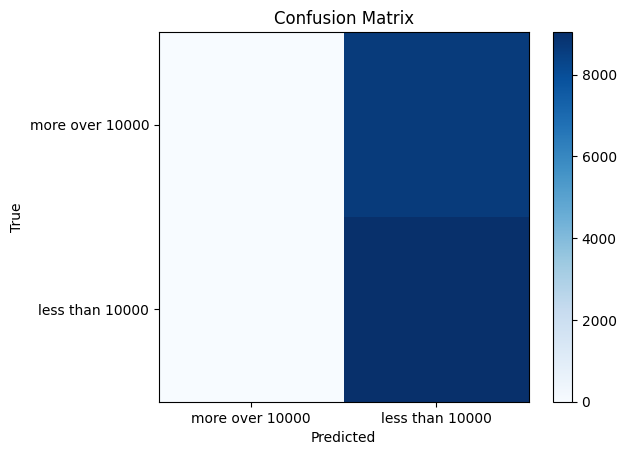

In [178]:
def confusion_matrix(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    tn = np.sum(np.logical_and(y_true == 0, y_pred == 0))
    
    return np.array([[tn, fp], [fn, tp]])

# Example usage:
threshold = 0.139
oof_df["pred_class"] = np.where(oof_df["pred"] >= threshold, 1, 0)
cm = confusion_matrix(oof_df["label"], oof_df["pred_class"])

print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")

class_names = ["more over 10000", "less than 10000"]  # Replace with your class names
plot_confusion_matrix(cm, class_names)
plt.show()

In [165]:
train = oof_df.copy()
df = oof_df.copy()

In [166]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27532 entries, 0 to 27531
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            27532 non-null  int64   
 1   region        27532 non-null  object  
 2   year          27532 non-null  int64   
 3   manufacturer  27532 non-null  object  
 4   condition     27532 non-null  category
 5   cylinders     27532 non-null  category
 6   fuel          27532 non-null  category
 7   title_status  27532 non-null  category
 8   transmission  27532 non-null  category
 9   drive         27532 non-null  category
 10  size          27532 non-null  category
 11  type          27532 non-null  category
 12  paint_color   27532 non-null  category
 13  state         27532 non-null  category
 14  price         27532 non-null  float64 
 15  flag          27532 non-null  object  
 16  year_map      27532 non-null  int64   
 17  price_map     27532 non-null  int64   
 18  fold  

In [167]:
def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [179]:
## numerical
CFG.numerical_features = ['year', "odometer"]

## category
CFG.categorical_features = ['region','manufacturer', 'condition', 'cylinders','fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'state'
                            ]
CFG.target_encoding_features = ['manufacturer','condition', 'transmission',]
CFG.count_encoding_features = ["region",'cylinders',"state"]
CFG.max_encoding_features = ['cylinders']
CFG.std_encoding_features = ["fuel"]
CFG.min_encoding_features = []
CFG.median_encoding_features = ["manufacturer", "condition"]


## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [180]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    
    X_train = X_train[X_train["pred"] < 0.139].reset_index(drop=True)
    X_valid = X_valid[X_valid["pred"] < 0.139].reset_index(drop=True)
    
    test_df = test.copy()
    
    # odometerの補正
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["year_map"])["odometer"].mean().reset_index()
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame):
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="year_map", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    test_df = replace_odometer(test_df, fillna_map)
    
    
    """
    def add_odometer_per_year(df: pd.DataFrame):
        df["elapsed_year"] = 2023 - df["year"]
        df["odometer_per_year"] = df["odometer"] / df["elapsed_year"]
        return df
    X_train = add_odometer_per_year(X_train)
    X_valid = add_odometer_per_year(X_valid) 
    test_df = add_odometer_per_year(test_df)
    """
    
    # CFG.categorical_featuresをcategory型に変換
    for col in CFG.categorical_features:
        try:
            X_train[col] = X_train[col].astype("category")
            X_valid[col] = X_valid[col].astype("category")
            test_df[col] = test_df[col].astype("category")
        except:
            pass
        
    # params
    lgb_param = {
        "objective": "mape",
        "metric": 'mape',
        "verbosity": -1,
        "seed" : CFG.seed,
    }


    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    num_boost_round=CFG.num_boost_round, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    X_valid["pred"] = X_valid["pred"].clip(upper=15000, lower=None)
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

fold0: 42.92541293857751
fold1: 44.03498937476718
fold2: 42.099175465359316
fold3: 42.39449018197828
fold4: 42.32271939555295
====== CV score ======
42.75600132378074


In [181]:
oof_df.shape

(8378, 23)

In [185]:
train = df.copy()

In [186]:
## numerical
CFG.numerical_features = ['year', "odometer"]

## category
CFG.categorical_features = ['region','manufacturer', 'condition', 'cylinders','fuel', 'title_status', 'transmission', 'drive', 'size',
                            'type', 'paint_color', 'state'
                            ]
CFG.target_encoding_features = ['manufacturer','condition', 'transmission',]
CFG.count_encoding_features = ["region",'cylinders',"state"]
CFG.max_encoding_features = ['cylinders']
CFG.std_encoding_features = ["fuel"]
CFG.min_encoding_features = []
CFG.median_encoding_features = ["manufacturer", "condition"]


## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [187]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    
    X_train = X_train[X_train["pred"] > 0.139].reset_index(drop=True)
    X_valid = X_valid[X_valid["pred"] > 0.139].reset_index(drop=True)
    
    test_df = test.copy()
    
    # odometerの補正
    fillna_map = X_train[(X_train["odometer"] > 100)&(X_train["odometer"] < 400000)].groupby(["year_map"])["odometer"].mean().reset_index()
    def replace_odometer(df: pd.DataFrame, fillna_map: pd.DataFrame):
        df_1 = df[(df["odometer"] < 100)|(df["odometer"] > 400000)].reset_index(drop=True)
        df_2 = df[(df["odometer"] >= 100)&(df["odometer"] <= 400000)].reset_index(drop=True)
        df_1.drop("odometer", inplace=True, axis=1)
        df_1 = pd.merge(df_1, fillna_map, on="year_map", how="left")
        df = pd.concat([df_1, df_2])
        return df.sort_values("id", ignore_index=True)
    X_train = replace_odometer(X_train, fillna_map)
    X_valid = replace_odometer(X_valid, fillna_map)
    test_df = replace_odometer(test_df, fillna_map)
    
    
    """
    def add_odometer_per_year(df: pd.DataFrame):
        df["elapsed_year"] = 2023 - df["year"]
        df["odometer_per_year"] = df["odometer"] / df["elapsed_year"]
        return df
    X_train = add_odometer_per_year(X_train)
    X_valid = add_odometer_per_year(X_valid) 
    test_df = add_odometer_per_year(test_df)
    """
    
    # CFG.categorical_featuresをcategory型に変換
    for col in CFG.categorical_features:
        try:
            X_train[col] = X_train[col].astype("category")
            X_valid[col] = X_valid[col].astype("category")
            test_df[col] = test_df[col].astype("category")
        except:
            pass
        
    # params
    lgb_param = {
        "objective": "mape",
        "metric": 'mape',
        "verbosity": -1,
        "seed" : CFG.seed,
    }


    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    num_boost_round=CFG.num_boost_round, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False),],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    #X_valid["pred"] = X_valid["pred"].clip(upper=15000, lower=None)
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

fold0: 47.57677122121436
fold1: 47.233012467069294
fold2: 46.02622493601859
fold3: 46.39433474520593
fold4: 46.719884451413975
====== CV score ======
46.78978945841658


In [188]:
oof_df.shape

(19154, 23)